# Predicting Real Disasters from Twitter

Frame the problem.

# Data

Discuss putting the data into a Postgres database.

In [1]:
from sqlalchemy import create_engine

db_pw = open('C:/Users/Jake/Documents/Projects/jakes_db.txt').read()

engine = create_engine('postgresql://postgres:%s@localhost:5432/disaster' % db_pw)
conn = engine.connect()

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)

train = pd.read_sql('SELECT * FROM train;', conn)

Take a look at the first 5 rows.

In [7]:
train.head()

index  id keyword location  \
0      0   1    None     None   
1      1   4    None     None   
2      2   5    None     None   
3      3   6    None     None   
4      4   7    None     None   

                                                                                                  text  \
0                                Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                               Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...   
3                                    13,000 people receive #wildfires evacuation orders in California    
4             Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [8]:
train.shape

(7613, 6)

In [9]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [3]:
train = train[['target', 'text']]
train.head()

target  \
0       1   
1       1   
2       1   
3       1   
4       1   

                                                                                                  text  
0                                Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all  
1                                                               Forest fire near La Ronge Sask. Canada  
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...  
3                                    13,000 people receive #wildfires evacuation orders in California   
4             Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school

# Data Cleaning Function

2. Tokenize
3. Clean Text - stopwords, punctuation, lower case, lemmatize/stem

In [4]:
import string
import re
import nltk

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

def clean_tweets(tweet):
    tweet = ''.join([c.lower() for c in tweet if c not in string.punctuation]) #remove punctuation
    tweet = re.split('\W+', tweet) #tokenize tweet
    tweet = [wn.lemmatize(word) for word in tweet if word not in stopwords and word != ''] #remove stopwords & lemmatize
    return(tweet)

train['clean_tweet'] = train['text'].apply(lambda x: clean_tweets(x))
train.head()

target  \
0       1   
1       1   
2       1   
3       1   
4       1   

                                                                                                  text  \
0                                Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                               Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...   
3                                    13,000 people receive #wildfires evacuation orders in California    
4             Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

                                                                                         clean_tweet  
0                                                 [deed, reason, earthquake, may, allah, forgive, u]  
1                                                      [forest, fire, near, la, ronge, sask, canada]  
2  [resident, asked, shelter, place, notified, officer, evacuation, shelter, place, order, expected]  
3                                  [13000, people, receive, wildfire, evacuation, order, california]  
4                                   [got, sent, photo, ruby, alaska, smoke, wildfire, pours, school]

# Feature Engineering

In [5]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline

def evaluate_feature(feature_name, bins):
    pyplot.hist(train[train['target'] == 1][feature_name], bins, alpha=0.5, label='disaster')
    pyplot.hist(train[train['target'] == 0][feature_name], bins, alpha=0.5, label='not disaster')
    pyplot.legend(loc='upper left')
    pyplot.title(feature_name)
    pyplot.show()

## Tweet Length

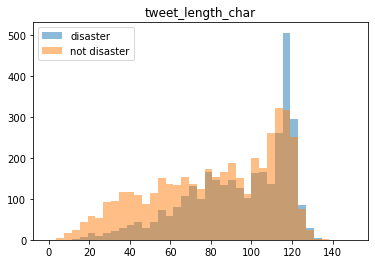

In [6]:
train['tweet_length_char'] = train['text'].apply(lambda x: len(x) - x.count(" "))

bins = np.linspace(0,150, 40)
evaluate_feature('tweet_length_char', bins)

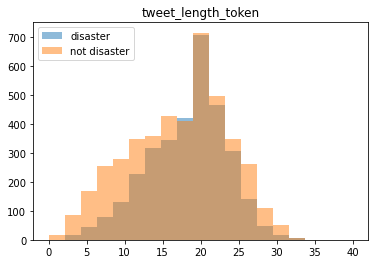

In [7]:
train['tweet_length_token'] = train['text'].apply(lambda x: len(re.split('\W+', x)))

bins = np.linspace(0,40, 20)
evaluate_feature('tweet_length_token', bins)

## Hashtags & Punctuation

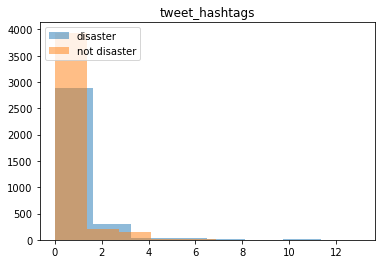

In [8]:
train['tweet_hashtags'] = train['text'].apply(lambda x: sum([1 for c in x if c == '#']))

evaluate_feature('tweet_hashtags', 8)

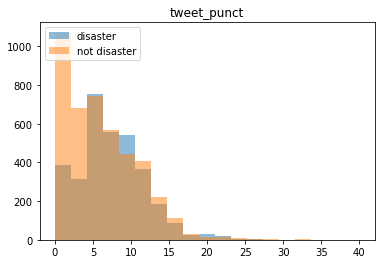

In [9]:
train['tweet_punct'] = train['text'].apply(lambda x: sum([1 for c in x if c in string.punctuation]))

bins = np.linspace(0,40, 20)
evaluate_feature('tweet_punct', bins)

# Vectorize
    - Counts
    - N-gram
    - TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_tweets)
train_tfidf = tfidf_vect.fit_transform(train['text'])

X_features = pd.concat([train[['tweet_length_char', 'tweet_length_token', 'tweet_hashtags', 'tweet_punct']], 
                        pd.DataFrame(train_tfidf.toarray())], axis=1)
X_features.head()

tweet_length_char  tweet_length_token  tweet_hashtags  tweet_punct    0  \
0                 57                  13               1            1  0.0   
1                 32                   7               0            1  0.0   
2                112                  22               0            3  0.0   
3                 57                  10               1            2  0.0   
4                 72                  17               2            2  0.0   

     1    2    3    4    5  ...  20989  20990  20991  20992  20993  20994  \
0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   

   20995  20996  20997  20998  
0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0  

[5 rows x 21003 columns]

# Applying Machine Learning Algorithms

## Random Forrest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

In [12]:
rf = RandomForestClassifier(n_jobs=-1)
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, 120, None],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 10, 20]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_features, train['target'])
rf_gs_results = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)
rf_gs_results[0:5]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
71     114.563360      8.959216         3.786686        1.154666   
32     148.300025     17.101207         4.583046        2.226819   
34      82.402567      5.287477         2.957500        1.147682   
22      78.323160      3.967970         2.913709        1.458264   
74     163.393412     21.079034         3.646602        1.709538   

   param_criterion param_max_depth param_min_samples_split param_n_estimators  \
71         entropy              90                      20                300   
32            gini             120                      10                300   
34            gini             120                      20                150   
22            gini              90                      10                150   
74         entropy             120                       2                300   

                                                                                     params  \
71  {'criterion': 'entropy', 'max_depth': 90, 'min_samples_split': 20, 'n_estimators': 300}   
32    {'criterion': 'gini', 'max_depth': 120, 'min_samples_split': 10, 'n_estimators': 300}   
34    {'criterion': 'gini', 'max_depth': 120, 'min_samples_split': 20, 'n_estimators': 150}   
22     {'criterion': 'gini', 'max_depth': 90, 'min_samples_split': 10, 'n_estimators': 150}   
74  {'criterion': 'entropy', 'max_depth': 120, 'min_samples_split': 2, 'n_estimators': 300}   

    split0_test_score  split1_test_score  split2_test_score  \
71           0.696651           0.647406           0.675640   
32           0.699934           0.639527           0.665791   
34           0.695338           0.650689           0.671044   
22           0.692055           0.644780           0.665135   
74           0.701904           0.642810           0.670387   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
71           0.647832           0.746386         0.682783        0.036775   
32           0.654402           0.749014         0.681734        0.039091   
34           0.647175           0.743101         0.681470        0.035279   
22           0.653088           0.751643         0.681340        0.038613   
74           0.640604           0.750986         0.681338        0.041321   

    rank_test_score  
71                1  
32                2  
34                3  
22                4  
74                5

In [19]:
rf_model_dir = 'C:/Users/Jake/Documents/Projects/Disaster-Tweets/models/random_forest'

rf_gs_results = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)
rf_gs_results.to_excel(rf_model_dir + '/rf_gs_results.xlsx', index=False)

dump(gs_fit.best_estimator_, rf_model_dir + '/rf_best.joblib')

['C:/Users/Jake/Documents/Projects/Disaster-Tweets/models/random_forest/rf_best.joblib']

In [20]:
rf_best = load(rf_model_dir + '/rf_best.joblib') 

### SVM

In [13]:
from sklearn.svm import SVC

svm = SVC()
param_svm = {'C': [1.0],
             'kernel': ['linear']}

gs_svm = GridSearchCV(svm, param_svm, cv=5, n_jobs=-1)
gs_svm_fit = gs_svm.fit(X_features, train['target'])
pd.DataFrame(gs_svm_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0    1558.353611    120.601278       265.818759       13.894475       1   

  param_kernel                          params  split0_test_score  \
0       linear  {'C': 1.0, 'kernel': 'linear'}           0.740643   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.638871           0.683519           0.695138           0.783837   

   mean_test_score  std_test_score  rank_test_score  
0         0.708402        0.049719                1